# Bayesian Hierarchical Clustering
## Prototype Build

The intent of this notebook is to implement a preliminary version of the *Bayesian Hierarchical Clustering* (BHC) algorithm.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from scipy import random as rnd
import matplotlib.pyplot as plt

### Generate Example Data

Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

In [2]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.4
p2 = 0.3
p3 = 1 - p2 - p1

# number of total draws
draws = 200

In [3]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

In [4]:
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}
clustData = pd.DataFrame(dat)

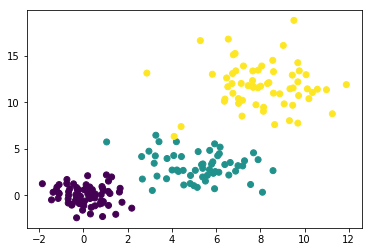

In [5]:
plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.show()

### Preliminary Algorithm

***BHC Steps:***


1. Input
    - Data: $D = \{\vec{x_1}, ..., \vec{x_n}\}$ 
    - Select generative model: $p(\vec{x} | \theta)$
    - Select appropriate prior: $p(\theta | \theta_0)$

2. Initialize Stage
    - Number of initial clusters: `c = len(D)`
    - $D_i = {\vec{x_i}}$ for $i = 1, ..., n$

3. Iterate Stage
    `while c > 1:`
    
    - find data pair $D_i$, $D_j$ w/ highest posterior probability for merge hypothesis: $r_k = p(H^1_k | D_k) = \frac{p(D_k | H^1_k)\pi_k}{p(D_k | T_k)}$
    - merge clusters $D_k = D_i \cup D_j$
    - delete old clusters $D_i$ and $D_j$
    - interate number of clusters `c -= 1`
    
   `end loop`

***Output:***

Bayesian mixture model where each tree node is a mixture component. Tree can be cut at points where $r_k < 0.5$.

### Building Algorithm Components

In [6]:
# define prior probability for hypothesis 1

def clust_k_prior(alpha, nk, dk):
    """Prior probability for merging clusters i, j into a single cluster k
    alpha - a cluster concentration parameter
    nk - the number of points in new cluster Dk
    dk -  """
    

In [7]:
# prior clusters test